In [45]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
%load_ext watermark
%watermark --python --datename --machine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 4.15.0-151-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [46]:
import os
from pathlib import Path

import matplotlib
matplotlib.use("pgf")

import pandas as pd
from sklearn.metrics import cohen_kappa_score
import sklearn
import scikitplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
%watermark --iversion

sklearn   : 0.24.2
numpy     : 1.21.1
pandas    : 1.1.4
scikitplot: 0.3.7
seaborn   : 0.11.1
matplotlib: 3.4.2



In [47]:
RAW_PANDA_DATASET_PATH = Path("/data/raw/panda")
TEST_SLIDES_PATH = RAW_PANDA_DATASET_PATH / "test_images/"
df_test = pd.read_csv(RAW_PANDA_DATASET_PATH/"test.csv")
df_derived = pd.read_csv(RAW_PANDA_DATASET_PATH/"derived.csv")

df_test = pd.merge(df_test, df_derived, on="image_id")
df_test = df_derived.rename(columns={"image_id": "slide_id"})

In [48]:
VERSION = "1"
DATASET = "external"
TYPE = "_majority"

In [49]:
# predictions_files = os.listdir("/tmp/predictions/")

# df_prediction = pd.DataFrame({"slide_id": [], "isup_grade_pred": []})

# for file in predictions_files:
#     df = pd.read_csv(os.path.join("/tmp/predictions/", file))
#     df_prediction = df_prediction.append(df)

# df_preds = pd.merge(df_test, df_prediction, on="slide_id")

df_preds = pd.read_csv(f"/app/out/{VERSION}-{DATASET}-predictions{TYPE}.csv")

In [50]:
df_preds["isup_grade_grouped"] = -1
df_preds["isup_grade_pred_grouped"] = -1

df_preds.loc[df_preds.isup_grade == 0, 'isup_grade_grouped'] = 0
df_preds.loc[df_preds.isup_grade == 1, 'isup_grade_grouped'] = 1
df_preds.loc[(df_preds.isup_grade == 2) | (df_preds.isup_grade == 3), 'isup_grade_grouped'] = 2
df_preds.loc[(df_preds.isup_grade == 4) | (df_preds.isup_grade == 5), 'isup_grade_grouped'] = 3

df_preds.loc[df_preds.isup_grade_pred == 0, 'isup_grade_pred_grouped'] = 0
df_preds.loc[df_preds.isup_grade_pred == 1, 'isup_grade_pred_grouped'] = 1
df_preds.loc[(df_preds.isup_grade_pred == 2) | (df_preds.isup_grade_pred == 3), 'isup_grade_pred_grouped'] = 2
df_preds.loc[(df_preds.isup_grade_pred == 4 )| (df_preds.isup_grade_pred == 5), 'isup_grade_pred_grouped'] = 3


targets = df_preds.isup_grade.to_numpy()
preds = df_preds.isup_grade_pred.to_numpy()

targets_grouped = df_preds.isup_grade_grouped.to_numpy()
preds_grouped = df_preds.isup_grade_pred_grouped.to_numpy()

accuracy = (preds == targets).mean()
accuracy_grouped = (preds_grouped == targets_grouped).mean()

qwk = cohen_kappa_score(preds, targets, weights="quadratic")
qwk_grouped = cohen_kappa_score(preds_grouped, targets_grouped, weights="quadratic")


print("TOTAL")
print("-----")
print("QWK:", qwk)
print("QWK Grouped:", qwk_grouped)
print("Accuracy:", accuracy)
print("Accuracy Grouped:", accuracy_grouped)

if DATASET == "internal":
    public_target = df_preds.loc[df_preds['Usage'] == "Public"].isup_grade.to_numpy()
    public_preds = df_preds.loc[df_preds['Usage'] == "Public"].isup_grade_pred.to_numpy()

    public_accuracy = (public_preds == public_target).mean()

    public_qwk = cohen_kappa_score(public_preds, public_target, weights='quadratic')

    private_target = df_preds.loc[df_preds['Usage'] == "Private"].isup_grade.to_numpy()
    private_preds = df_preds.loc[df_preds['Usage'] == "Private"].isup_grade_pred.to_numpy()

    private_accuracy = (private_preds == private_target).mean()

    private_qwk = cohen_kappa_score(private_preds, private_target, weights='quadratic')
    
    print("")

    print("Public")
    print("-----")
    print("QWK:", public_qwk)
    print("Accuracy:",public_accuracy)

    print("")

    print("Private")
    print("-----")
    print("QWK:", private_qwk)
    print("Accuracy:", private_accuracy)

TOTAL
-----
QWK: 0.9094702011260434
QWK Grouped: 0.9146753022295399
Accuracy: 0.7377398720682303
Accuracy Grouped: 0.8230277185501066

Public
-----
QWK: 0.8953849324420058
Accuracy: 0.7353689567430025

Private
-----
QWK: 0.9198234187919172
Accuracy: 0.7394495412844037


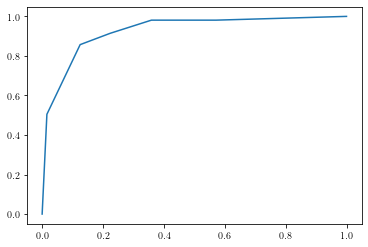

In [51]:
fpr, tpr, thresholds = scikitplot.metrics.roc_curve(targets, preds, pos_label=5)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

In [52]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [53]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

inten_fig_out_dir = Path("/app/out/figures")
inten_fig_out_dir.mkdir(parents=True, exist_ok=True)

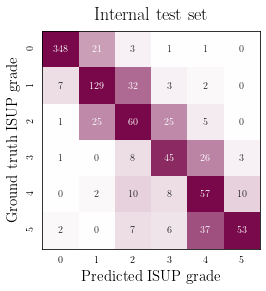

In [54]:
def plot_cf_total(targets, preds):
    cf_matrix = sklearn.metrics.confusion_matrix(targets, preds)

    colours = ["#ffffff", "#79084a", "#79084a"]
    ki_cmap = get_continuous_cmap(colours, (0, 0.15, 1))

    ax = sns.heatmap(cf_matrix, annot=True, cmap=ki_cmap, cbar=False, square=True, fmt='g', linewidths=0)

    ax.set_ylabel("Ground truth ISUP grade", labelpad=6, fontsize=15)
    ax.set_xlabel("Predicted ISUP grade", labelpad=6, fontsize=15)

    ax.set_frame_on(True)

    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    ax.set_title(f"{DATASET.capitalize()} test set", pad=12, fontsize=18)

    for _, spine in ax.spines.items():
        spine.set_visible(True)

plot_cf_total(targets, preds)
plt.savefig(inten_fig_out_dir/ f"{DATASET}_grading_heatmap.pgf")

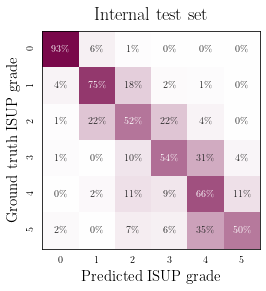

In [55]:
def plot_cf_percentage(targets, preds):
    colours = ["#ffffff", "#79084a"]
    ki_cmap = get_continuous_cmap(colours)


    cf_matrix_percentage = sklearn.metrics.confusion_matrix(targets, preds)

    cf_matrix_percentage = np.true_divide(cf_matrix_percentage, cf_matrix_percentage.sum(axis=1, keepdims=True)) * 100

    ax = sns.heatmap(cf_matrix_percentage, annot=True, cmap=ki_cmap, cbar=False, square=True, linewidths=0, fmt='0.0f')

    for t in ax.texts:
        t.set_text(t.get_text() + "\%")

    ax.set_ylabel("Ground truth ISUP grade", labelpad=6, fontsize=15)
    ax.set_xlabel("Predicted ISUP grade", labelpad=6, fontsize=15)

    ax.set_frame_on(True)

    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')

    ax.set_title(f"{DATASET.capitalize()} test set", pad=12, fontsize=18)

    for _, spine in ax.spines.items():
        spine.set_visible(True)

plot_cf_percentage(targets, preds)
plt.savefig(inten_fig_out_dir/ f"{DATASET}_grading_heatmap_percentage.pgf")